In [43]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,plot_edge_width
)
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
)
from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plates = [
    "799_20211001",
    "803_20211012",
    "809_20211012",
    "907_20220321",
    "943_20220322",
    "403_20221005",
    "408_20221013",
    "88_20210915",
    "790_20210907",
    "69_20201119",
    "94_20201123",
    "59_20201126"
]
directory_targ = directory_project
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/1793 [00:00<?, ?it/s]

In [40]:
from amftrack.pipeline.launching.run_super import run_parallel, run_launcher

folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.loc[folders["/Analysis/skeleton_realigned_compressed.mat"] == True]
num_parallel = 128
time = "1:00:00"
skip = False
resolution = 10
args = [directory_targ, skip, resolution]
run_parallel(
    "extract_betweeness.py",
    args,
    folders,
    num_parallel,
    time,
    "betweenness",
    cpus=128,
    node="fat",
    name_job='bet',
)

Submitted batch job 2347604


In [47]:
folders = all_folders.loc[all_folders["unique_id"]=='94_20201123']
folders = folders.sort_values(by="datetime")
folders = folders.iloc[80:82]

exp = Experiment(directory_targ)
exp.load(folders)
exp.dates.sort()
for t in range(len(folders)):
    exp.load_tile_information(t)

2020-11-26 21:09:00
2020-11-26 22:09:00


In [48]:
load_graphs(exp,directory_targ)
exp.save_location = ''

load_study_zone(exp)


In [40]:
betweenessses = list(current_flow_betweeness.values())
np.max(betweenessses),np.mean(betweenessses)

(0.0018950251397544693, 0.0002368890640127486)

(array([1.000e+00, 6.000e+00, 4.700e+01, 1.059e+03, 3.110e+02, 3.150e+02,
        5.390e+02, 7.970e+02, 6.300e+02, 1.720e+02]),
 array([-6.96978048, -6.59257322, -6.21536595, -5.83815869, -5.46095142,
        -5.08374416, -4.70653689, -4.32932963, -3.95212236, -3.5749151 ,
        -3.19770783]),
 <BarContainer object of 10 artists>)

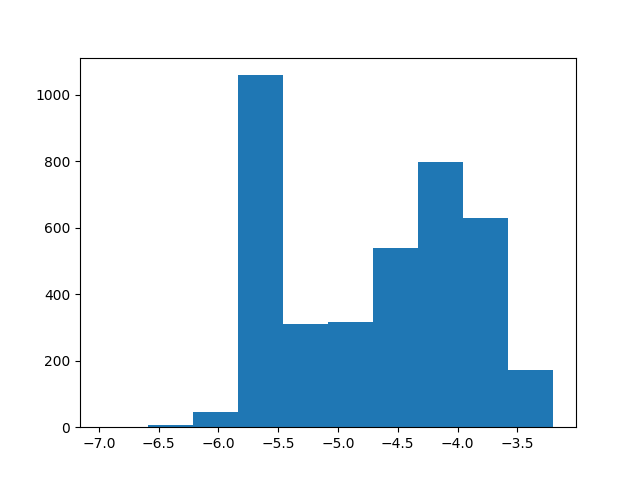

In [70]:
betweenessses = list(current_flow_betweeness.values())
betweenessses = [betweeness for betweeness in betweenessses if betweeness>1e-7]
np.max(betweenessses),np.mean(betweenessses)
fig,ax = plt.subplots()
ax.hist(np.log10(betweenessses))

In [49]:
edges = get_all_edges(exp, t)
nodes = get_all_nodes(exp, t)

In [50]:
nodes_source = [node for node in nodes if not is_in_study_zone(node,t,1000,150)[1] and is_in_study_zone(node,t,1000,150)[0]]

In [51]:

nodes_sink = [node for node in nodes if is_in_study_zone(node,t,1000,150)[1] and node.degree(t)==1]

In [52]:
weights = {(edge.begin.label,edge.end.label) : edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t] , weights, "length")


In [53]:
G = exp.nx_graph[t]
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len_connected=[len(nx_graph.nodes) for nx_graph in S]
G_connected = S[np.argmax(len_connected)]
source = [node.label for node in nodes_source if node.label in G_connected]
sink = [node.label for node in nodes_sink if node.label in G_connected]
current_flow_betweeness = nx.edge_current_flow_betweenness_centrality_subset(G_connected,source,sink,weight = "length")
betweeness = nx.edge_betweenness_centrality_subset(G_connected,source,sink,normalized=True,weight = "length")
for edge in exp.nx_graph[t].edges:
    if edge not in current_flow_betweeness.keys() and (edge[1],edge[0]) not in current_flow_betweeness.keys():
        current_flow_betweeness[edge] = 0
        betweeness[edge] = 0        
nx.set_edge_attributes(exp.nx_graph[t] , current_flow_betweeness, "current_flow_betweenness")
nx.set_edge_attributes(exp.nx_graph[t] , betweeness, "betweenness")
betweenessses = list(current_flow_betweeness.values())
np.mean(betweenessses),np.max(betweenessses)
nodes = [node for node in nodes_source if node.label in G_connected]

In [76]:
betweenessses = list(current_flow_betweeness.values())
vmax = np.log10(np.max(betweenessses))
vmax

-3.19770783290429

(array([210., 169., 223., 339., 306., 329., 284., 225., 130.,  31.]),
 array([-4.9984575 , -4.81441784, -4.63037818, -4.44633852, -4.26229887,
        -4.07825921, -3.89421955, -3.71017989, -3.52614023, -3.34210057,
        -3.15806091]),
 <BarContainer object of 10 artists>)

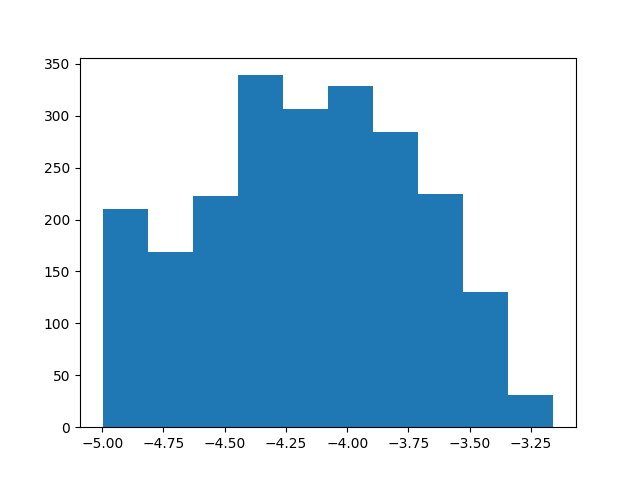

In [54]:
betweenessses = [edge.current_flow_betweeness(t) for edge in edges]
betweenessses = [betweeness for betweeness in betweenessses if betweeness>1e-5]
np.max(betweenessses),np.mean(betweenessses)
fig,ax = plt.subplots()
ax.hist(np.log10(betweenessses))

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


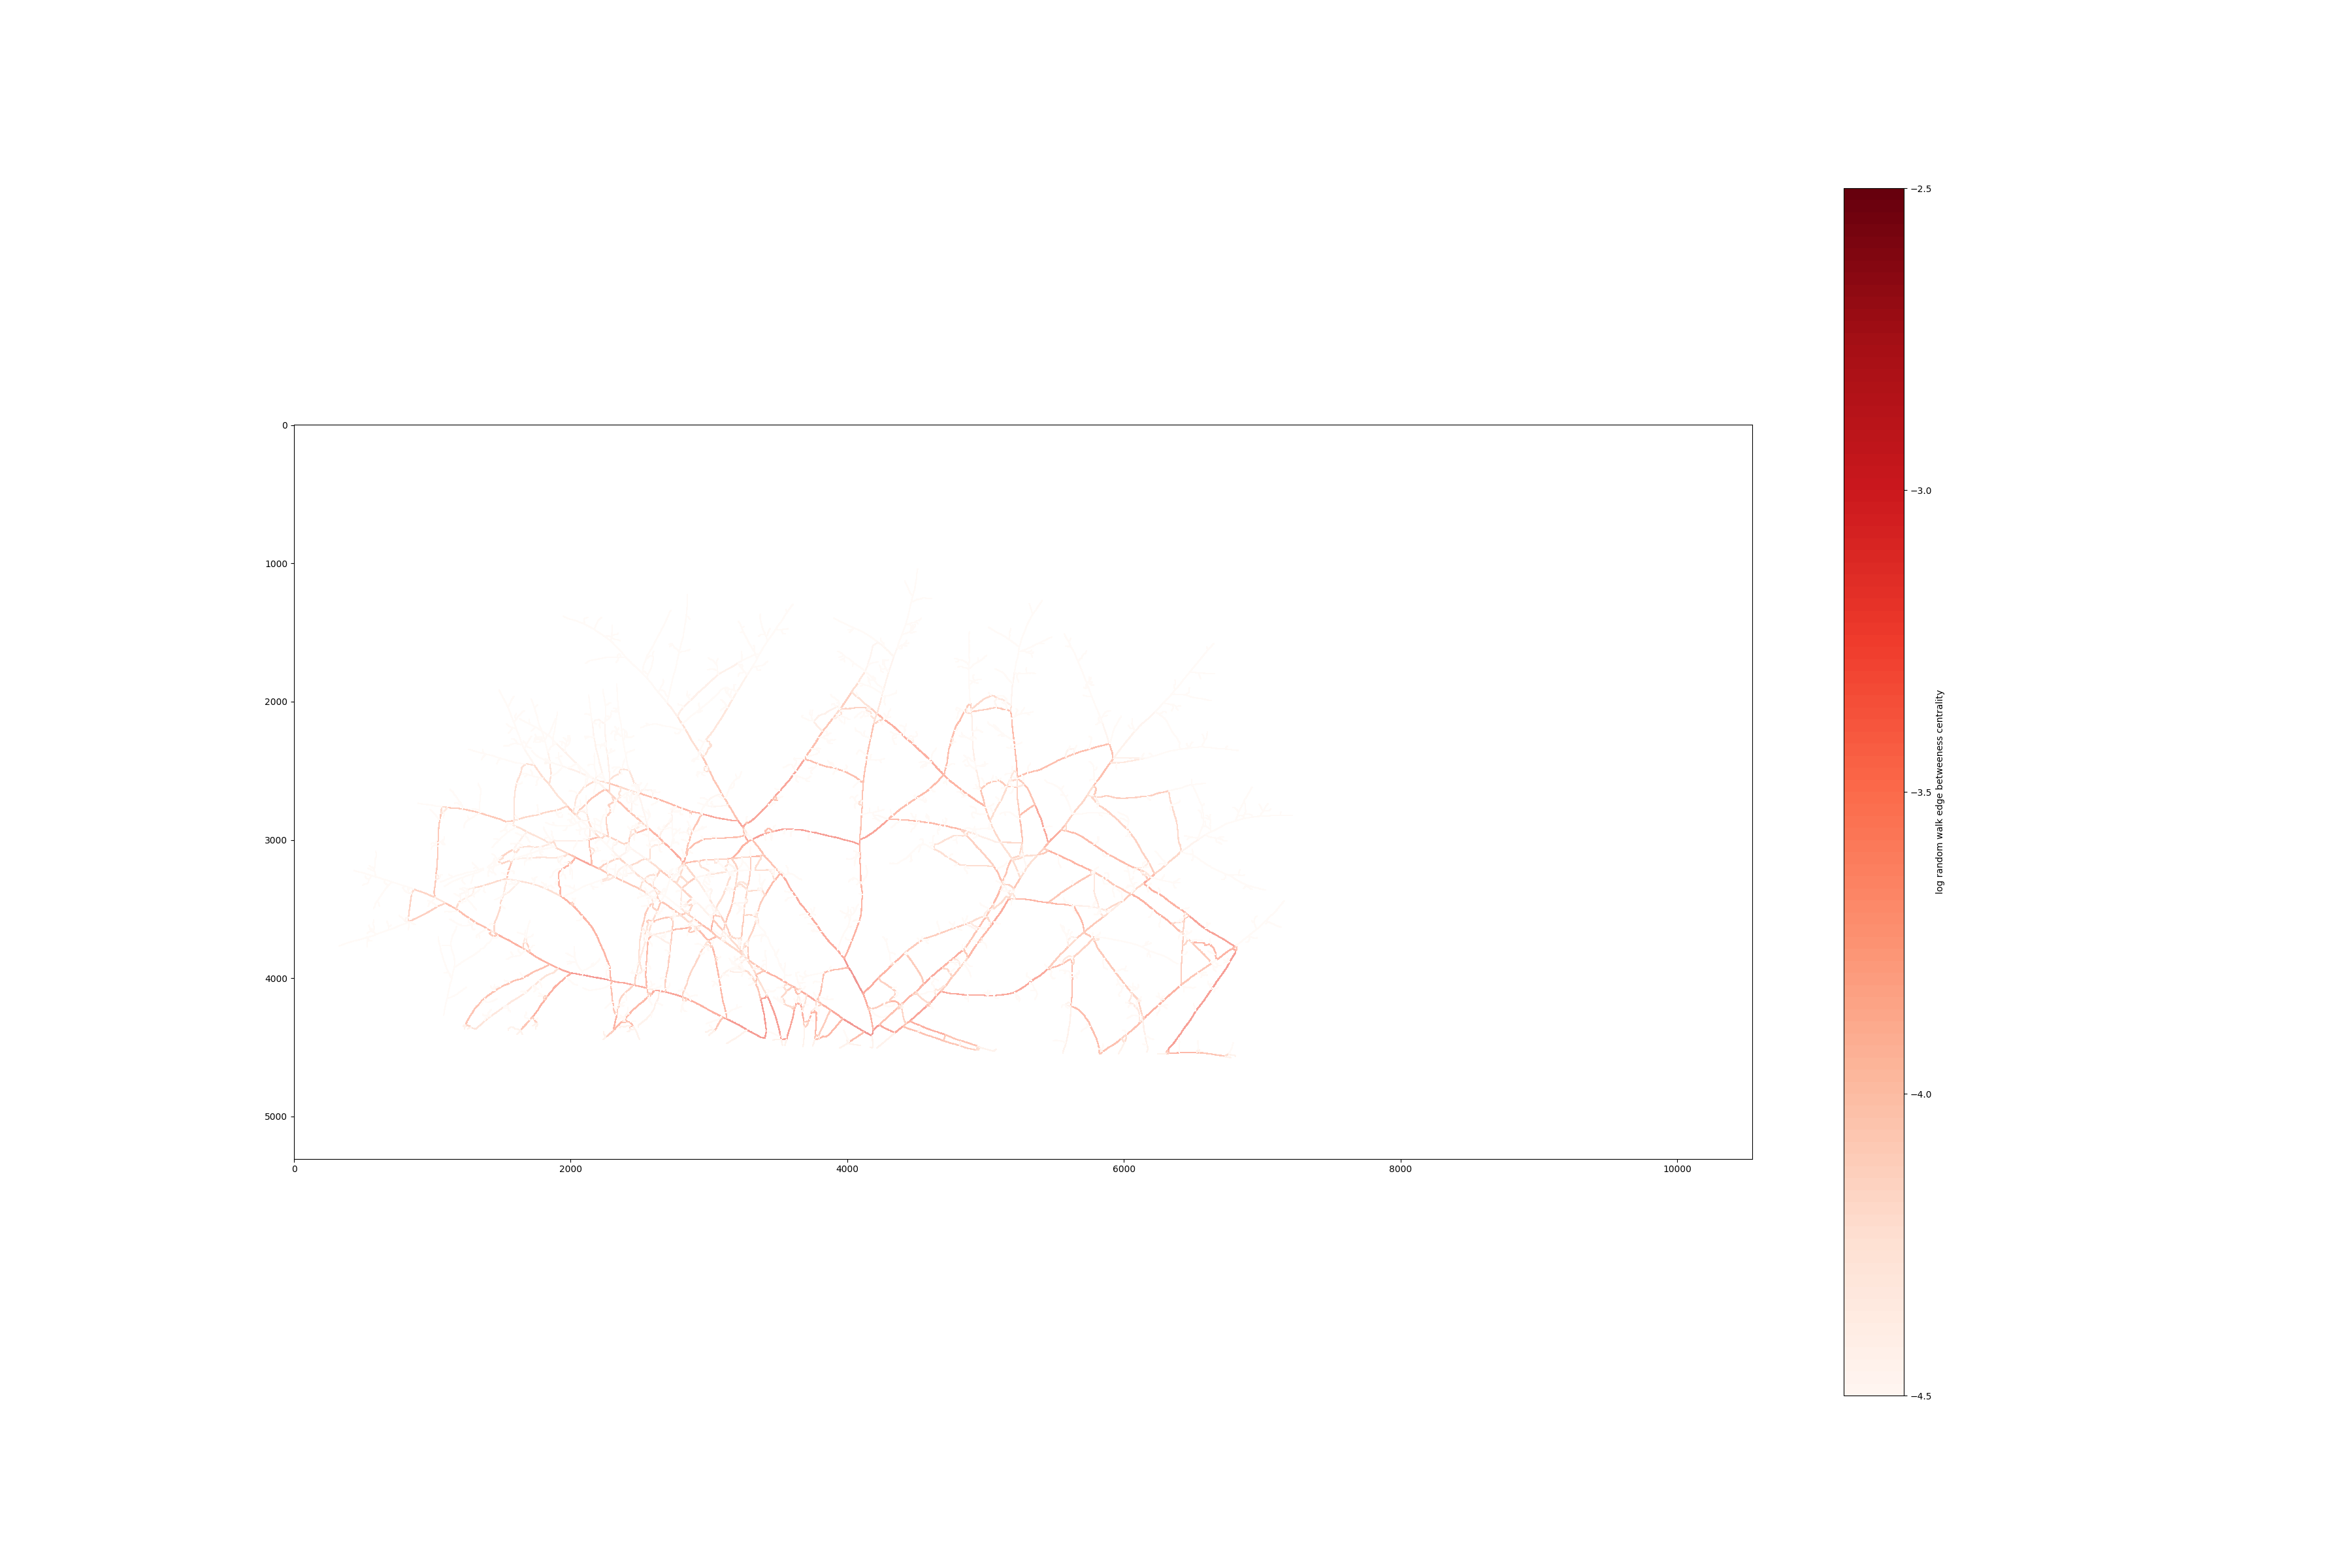

<AxesSubplot:>

In [55]:
plt.close("all")
t = 1 
# betweenessses = list(current_flow_betweeness.values())
vmax = -2.5
vmin = -4.5

plot_edge_width(exp,t,lambda edge : np.log10(edge.current_flow_betweeness(t)),cmap = cm.get_cmap("Reds", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10,label_colorbar = "log random walk edge betweeness centrality")

(array([  5.,   9.,  14.,  14., 218., 106.,  78.,  45.,  53.,  22.]),
 array([-5.44114505, -5.11320117, -4.78525729, -4.45731341, -4.12936953,
        -3.80142565, -3.47348177, -3.1455379 , -2.81759402, -2.48965014,
        -2.16170626]),
 <BarContainer object of 10 artists>)

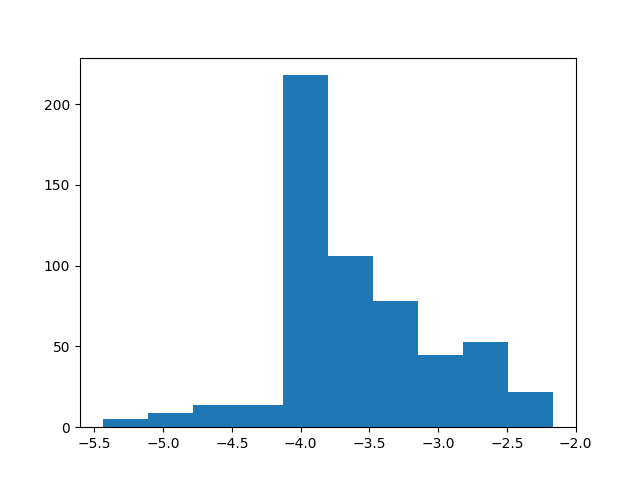

In [37]:
betweenessses = [edge.betweeness(t) for edge in edges]
betweenessses = [betweeness for betweeness in betweenessses if betweeness>0]
np.max(betweenessses),np.mean(betweenessses)
fig,ax = plt.subplots()
ax.hist(np.log10(betweenessses))

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


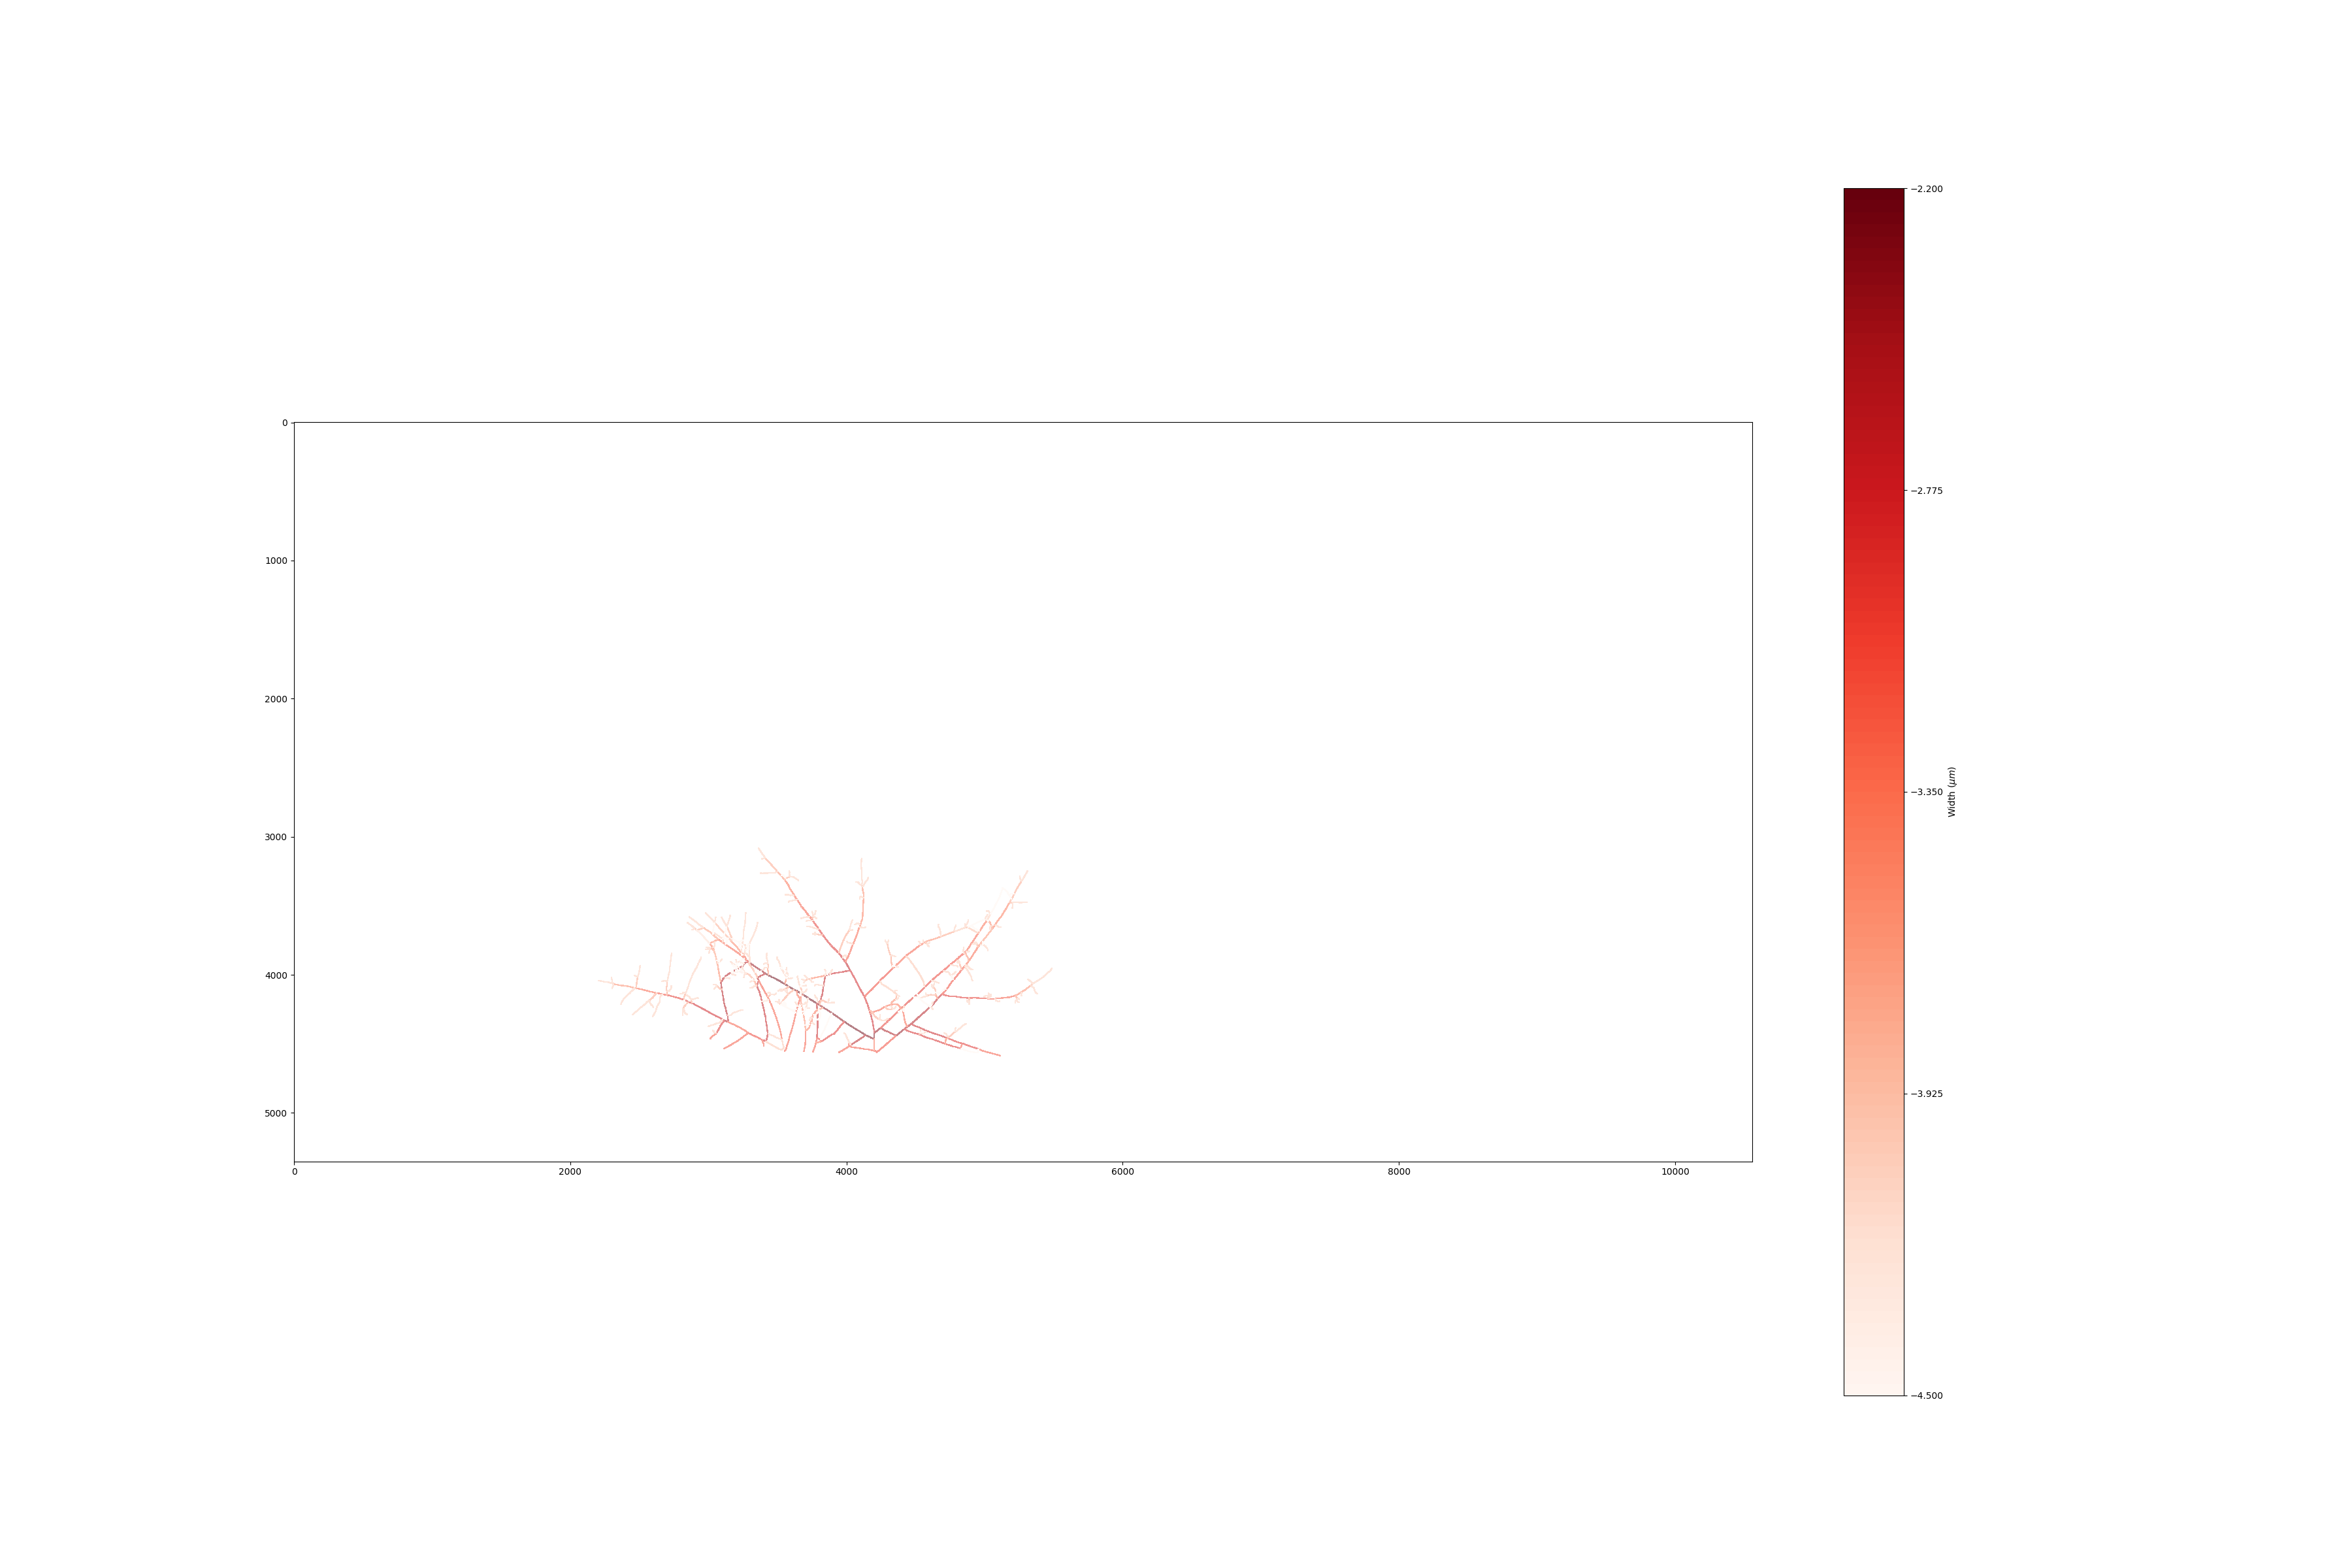

In [46]:
vmax = -2.2
vmin = -4.5
plot_edge_width(exp,t,lambda edge : np.log10(edge.betweeness(t)),cmap = cm.get_cmap("Reds", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10)